In [1]:
import rioxarray as rxr
import pandas as pd
import numpy as np
import rasterio

# Paths
landcover_raster_path = "/explore/nobackup/people/spotter5/helene/raw/TEM_Landcover_V4.tif"
reclass_csv = "/explore/nobackup/people/spotter5/helene/raw/TEMLandcoverClassDictionary_v2.csv"  # << new CSV
output_raster_path = "/explore/nobackup/people/spotter5/anna_v/v2/TEM_Landcover_Reclassified_v2.tif"
nodata_value = -9999

# Load landcover raster
landcover_raster = rxr.open_rasterio(landcover_raster_path, masked=True).squeeze()
landcover_values = landcover_raster.values
transform = landcover_raster.rio.transform()
crs = landcover_raster.rio.crs
height, width = landcover_values.shape

# Load and prepare reclassification mapping from v2 CSV
class_df = pd.read_csv(reclass_csv)

# Normalize headers and key columns
class_df.columns = class_df.columns.str.strip()
# Ensure types are numeric where needed
class_df["Value"] = pd.to_numeric(class_df["Value"], errors="coerce").astype("Int64")
class_df["Reclass"] = pd.to_numeric(class_df["Reclass"], errors="coerce").astype("Int64")

# Build dict: original value -> new class code
reclass_map = (
    class_df.dropna(subset=["Value", "Reclass"])
            .set_index("Value")["Reclass"]
            .astype(int)
            .to_dict()
)

# Reclassify (unmapped and masked -> nodata)
vals_int = landcover_values.astype(np.int32, copy=False)
out = np.full((height, width), nodata_value, dtype="int16")

for orig_val, new_val in reclass_map.items():
    mask = vals_int == int(orig_val)
    # If source is masked array with NaNs, this respects them (mask stays False where NaN)
    out[mask] = int(new_val)

# Also ensure NaNs in source become nodata in output
if np.issubdtype(landcover_values.dtype, np.floating):
    out[np.isnan(landcover_values)] = nodata_value

# Save reclassified raster (tiled + compressed)
profile = {
    "driver": "GTiff",
    "height": height,
    "width": width,
    "count": 1,
    "dtype": "int16",
    "crs": crs,
    "transform": transform,
    "nodata": nodata_value,
    "compress": "LZW",
    "tiled": True,
    "blockxsize": 512,
    "blockysize": 512,
    "BIGTIFF": "IF_SAFER",
}

with rasterio.open(output_raster_path, "w", **profile) as dst:
    dst.write(out, 1)

print(f"✅ Reclassified landcover raster saved to: {output_raster_path}")


✅ Reclassified landcover raster saved to: /explore/nobackup/people/spotter5/anna_v/v2/TEM_Landcover_Reclassified_v2.tif


Now extract land cover

0: "evergreen needleleaf",
1: "deciduous broadleaf/mixed",
2: "larch",
3: "tundra/herbaceous",
4: "wetlands/other"


In [1]:
import geopandas as gpd
import rioxarray as rxr
import pandas as pd
import xarray as xr

# Paths
shapefile_path = "/explore/nobackup/people/spotter5/anna_v/v2/v2_model_sites.shp"
tif_path       = "/explore/nobackup/people/spotter5/anna_v/v2/TEM_Landcover_Reclassified_v2.tif"
reclass_csv    = "/explore/nobackup/people/spotter5/helene/raw/TEMLandcoverClassDictionary_v2.csv"
output_csv_path= "/explore/nobackup/people/spotter5/anna_v/v2/extracted_landcover_values_v2.csv"

# 1) Load shapefile and raster
print("Loading data...")
sites_gdf = gpd.read_file(shapefile_path)
landcover_raster = rxr.open_rasterio(tif_path).squeeze()

# 2) CRS align
print("Aligning coordinate systems...")
sites_reprojected = sites_gdf.to_crs(landcover_raster.rio.crs)

# 3) Extract raster values at point locations
print("Extracting raster values...")
x_coords = xr.DataArray(sites_reprojected.geometry.x, dims="point")
y_coords = xr.DataArray(sites_reprojected.geometry.y, dims="point")

extracted_values = landcover_raster.sel(
    x=x_coords, y=y_coords, method="nearest"
)
sites_reprojected['land_cover_code'] = extracted_values.values

# 4) Load mapping dictionary (Value -> New Name)
print("Loading reclassification mapping...")
class_df = pd.read_csv(reclass_csv)
class_df.columns = class_df.columns.str.strip()
class_df["Reclass"] = pd.to_numeric(class_df["Reclass"], errors="coerce").astype("Int64")
class_df["New Name"] = class_df["New Name"].astype(str).str.strip()
code_to_name = class_df.set_index("Reclass")["New Name"].dropna().to_dict()

# 5) Map codes to string names
sites_reprojected["land_cover_name"] = sites_reprojected["land_cover_code"].map(code_to_name)

# 6) Build final DataFrame (keep only 'tower' rows)
final_df = sites_reprojected.drop(columns='geometry').dropna().copy()

# Keep rows where site_refer contains "tower" (case-insensitive)
mask_tower = final_df['site_refer'].str.contains("tower", case=False, na=False)
kept_count = mask_tower.sum()
final_df = final_df[mask_tower]

print(f"Kept {kept_count} rows where site_refer contained 'tower'.")

# Save results
print(f"Saving results to {output_csv_path}...")
final_df.to_csv(output_csv_path, index=False)

print("\nProcessing complete.")
print("First 5 rows of the cleaned output:")
print(final_df.head())


Loading data...
Aligning coordinate systems...
Extracting raster values...
Loading reclassification mapping...
Kept 197 rows where site_refer contained 'tower'.
Saving results to /explore/nobackup/people/spotter5/anna_v/v2/extracted_landcover_values_v2.csv...

Processing complete.
First 5 rows of the cleaned output:
                                site_refer   latitude   longitude  \
9                  Lost Creek_US-Los_tower  46.082700  -89.979200   
19  Marcell Bog Lake Peatland_US-MBP_tower  47.505100  -93.489300   
20           Newdale Manitoba_CA-EM1_tower  50.362300 -100.202400   
21            Park Falls/WLEF_US-PFa_tower  45.945900  -90.272300   
22                 Skyttorp 2_SE-Sk2_tower  60.129667   17.840056   

    land_cover_code land_cover_name  
9                13    Unclassified  
19               13    Unclassified  
20               13    Unclassified  
21               13    Unclassified  
22                7      Herbaceous  


In [2]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

import numpy as np
import pandas as pd
import geopandas as gpd
import rioxarray as rxr
import rasterio
from rasterio.windows import Window
from rasterio.transform import xy
from pyproj import CRS, Transformer
from pathlib import Path
from math import ceil

# ---------------- CONFIG ----------------
shapefile_path  = "/explore/nobackup/people/spotter5/anna_v/v2/v2_model_sites.shp"
tif_path        = "/explore/nobackup/people/spotter5/anna_v/v2/TEM_Landcover_Reclassified_v2.tif"
reclass_csv     = "/explore/nobackup/people/spotter5/helene/raw/TEMLandcoverClassDictionary_v2.csv"
output_csv_path = "/explore/nobackup/people/spotter5/anna_v/v2/extracted_landcover_values_v2.csv"

# fill distance threshold (meters)
TOL_M = 30_000

print("Loading data...")
sites_gdf = gpd.read_file(shapefile_path)

# Open with rioxarray for easy masking (set 13 -> NaN), keep data lazy/read via rasterio later
rarr = rxr.open_rasterio(tif_path, masked=True).squeeze()   # (y, x)
if rarr.ndim != 2:
    raise RuntimeError(f"Expected single-band raster; got shape {rarr.shape}")
# Treat class 13 as missing
rarr = rarr.where(rarr != 13, np.nan)

# Raster CRS
raster_crs = rarr.rio.crs
if raster_crs is None:
    raise RuntimeError("Raster has no CRS defined.")
print(f"Raster CRS: {raster_crs}")

# Reproject sites to raster CRS
print("Aligning coordinate systems...")
sites = sites_gdf.to_crs(raster_crs).copy()

# Prepare outputs
land_cover_codes = np.full(len(sites), np.nan, dtype=float)

# Use rasterio for indexing & reads
with rasterio.open(tif_path) as src:
    # We will use the masked array values from rioxarray for NaN logic,
    # but we also need src.transform and pixel size from rasterio
    transform = src.transform
    nodata = src.nodata
    crs = CRS.from_wkt(src.crs.to_wkt()) if hasattr(src.crs, "to_wkt") else CRS.from_string(str(src.crs))

    # Read pixel size (meters). EASE-Grid is projected in meters.
    # Pixel size ~ abs(transform.a), abs(transform.e)
    res_x = abs(transform.a)
    res_y = abs(transform.e)
    base_res = min(res_x, res_y)
    # Search radius in pixels for 30 km
    R_PIX = int(ceil(TOL_M / base_res))

    # Create a small helper to read a window as a numpy array with NaNs for
    # both nodata and class 13 (we’ve already converted 13->NaN in rarr, so we’ll use rarr.data for NaN truth).
    # To avoid reading the entire raster via rioxarray, we’ll read the window from rasterio and
    # independently map 13->NaN if present; also convert nodata to NaN.
    def read_window_as_nan(row, col, rad):
        # Clamp window to raster bounds
        r0 = max(0, row - rad)
        r1 = min(src.height - 1, row + rad)
        c0 = max(0, col - rad)
        c1 = min(src.width - 1, col + rad)
        h = r1 - r0 + 1
        w = c1 - c0 + 1
        window = Window.from_slices((r0, r1 + 1), (c0, c1 + 1))

        arr = src.read(1, window=window).astype(float)  # read single band
        # Map nodata -> NaN
        if nodata is not None:
            arr[arr == nodata] = np.nan
        # Map 13 -> NaN (treat as missing)
        arr[arr == 13] = np.nan
        return arr, r0, c0

    # If raster CRS is geographic (shouldn’t be for EASE), convert coordinates to metric for distance.
    # For safety, handle both cases.
    if crs.is_geographic:
        metric_crs = CRS.from_epsg(3413)
        to_metric = Transformer.from_crs(crs, metric_crs, always_xy=True).transform
    else:
        to_metric = None  # already meters

    # Iterate sites
    print("Sampling values with 30 km fill for NaNs (13-class) ...")
    xs = sites.geometry.x.to_numpy()
    ys = sites.geometry.y.to_numpy()

    # First: try direct nearest pixel at the exact point location
    # Then, if NaN, search neighborhood within R_PIX for nearest non-NaN.
    for i, (x_pt, y_pt) in enumerate(zip(xs, ys)):
        # Row/col of the point
        row, col = src.index(x_pt, y_pt)

        # Quick bounds check
        if row < 0 or row >= src.height or col < 0 or col >= src.width:
            # out of raster — cannot fill, set to 13
            land_cover_codes[i] = 13
            continue

        # Sample nearest pixel value at the point
        val = next(src.sample([(x_pt, y_pt)]))[0]
        # Map nodata/13 to NaN
        if (nodata is not None and val == nodata) or (val == 13):
            val = np.nan

        if not np.isnan(val):
            # We landed on a real value — accept it (no distance check needed)
            land_cover_codes[i] = val
            continue

        # Need to fill: search in a local window up to R_PIX
        arr, r0, c0 = read_window_as_nan(row, col, R_PIX)

        # If the entire window is NaN, nothing to fill
        if np.all(np.isnan(arr)):
            land_cover_codes[i] = 13  # Unclassified
            continue

        # Build arrays of candidate pixel centers in the window
        H, W = arr.shape
        # Row/col indices in the window
        rr = np.arange(r0, r0 + H)
        cc = np.arange(c0, c0 + W)
        # 2D grids
        RR, CC = np.meshgrid(rr, cc, indexing="ij")

        # Pixel center coordinates (in raster CRS)
        # vectorized conversion: xy can take arrays in newer rasterio; for full compatibility, do per-row
        # We'll compute centers from transform directly:
        # col, row -> x = a*col + b*row + c  ; y = d*col + e*row + f
        # For standard north-up transforms, b=d=0, a=res_x, e=-res_y, etc.
        x_centers = transform.c + CC * transform.a + RR * transform.b
        y_centers = transform.f + CC * transform.d + RR * transform.e

        # Compute distances from point to each pixel center in meters
        if to_metric is not None:
            x_pt_m, y_pt_m = to_metric(x_pt, y_pt)
            x_c_m, y_c_m = to_metric(x_centers, y_centers)
            dx = x_c_m - x_pt_m
            dy = y_c_m - y_pt_m
        else:
            dx = x_centers - x_pt
            dy = y_centers - y_pt

        dist2 = dx * dx + dy * dy
        # Mask out NaNs
        mask_valid = ~np.isnan(arr)
        if not np.any(mask_valid):
            land_cover_codes[i] = 13
            continue

        # Among valid pixels, find the nearest (min distance)
        nearest_idx = np.argmin(np.where(mask_valid, dist2, np.inf))
        nr = nearest_idx // W
        nc = nearest_idx % W

        # Check distance threshold (<= 30 km)
        # (Use squared distance to avoid sqrt until needed)
        if dist2[nr, nc] <= (TOL_M * TOL_M):
            land_cover_codes[i] = arr[nr, nc]
        else:
            land_cover_codes[i] = 13  # too far → Unclassified

# Attach codes to sites
sites["land_cover_code"] = pd.Series(land_cover_codes, index=sites.index)

# --- Reclassification names ---
print("Loading reclassification mapping...")
class_df = pd.read_csv(reclass_csv)
class_df.columns = class_df.columns.str.strip()
if not {"Reclass", "New Name"}.issubset(class_df.columns):
    raise RuntimeError("Reclass CSV must have columns 'Reclass' and 'New Name'.")

class_df["Reclass"] = pd.to_numeric(class_df["Reclass"], errors="coerce").astype("Int64")
class_df["New Name"] = class_df["New Name"].astype(str).str.strip()

code_to_name = class_df.set_index("Reclass")["New Name"].to_dict()

# Map names; enforce 13 -> "Unclassified" regardless of CSV
names = []
for v in sites["land_cover_code"]:
    if np.isnan(v):
        # Shouldn't happen (we back-fill to 13), but guard anyway
        names.append("Unclassified")
    else:
        iv = int(v)
        names.append("Unclassified" if iv == 13 else code_to_name.get(iv, "Unclassified"))

sites["land_cover_name"] = names

# Keep only rows with 'tower' in site_refer (case-insensitive)
if "site_refer" not in sites.columns:
    raise RuntimeError("Expected column 'site_refer' not found in sites file.")
mask_tower = sites["site_refer"].astype(str).str.contains("tower", case=False, na=False)
final_df = sites.loc[mask_tower].drop(columns="geometry").copy()

# Save
out_path = Path(output_csv_path)
out_path.parent.mkdir(parents=True, exist_ok=True)
print(f"Saving results to {out_path}...")
final_df.to_csv(out_path, index=False)

print("\nProcessing complete.")
print(final_df.head())


Loading data...
Raster CRS: COMPD_CS["WGS 84 / NSIDC EASE-Grid 2.0 North + EGM96 height",PROJCS["WGS 84 / NSIDC EASE-Grid 2.0 North",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Lambert_Azimuthal_Equal_Area"],PARAMETER["latitude_of_center",90],PARAMETER["longitude_of_center",0],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",SOUTH],AXIS["Northing",SOUTH],AUTHORITY["EPSG","6931"]],VERT_CS["EGM96 height",VERT_DATUM["EGM96 geoid",2005,AUTHORITY["EPSG","5171"]],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Gravity-related height",UP],AUTHORITY["EPSG","5773"]]]
Aligning coordinate systems...
Sampling values with 30 km fill for NaNs (13-class) ...
Loading reclassification mapping...
Saving results to /exp

In [4]:
final_df['land_cover_name'].value_counts()

land_cover_name
Shrub               41
Spruce              28
Pine                26
Unclassified        26
Barren/Other        18
Gram-Tundra         15
Deciduous           12
Wetland              9
Larch                9
Mixed                6
Herbaceous           5
Alpine-Shrubland     4
Name: count, dtype: int64

Extract from original source

Loading extracted landcover data...
Generating plot and saving to /explore/nobackup/people/spotter5/anna_v/v2/landcover_distribution_sites_percent.png...


/explore/nobackup/people/spotter5/temp_dir/ipykernel_1372569/1628316713.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


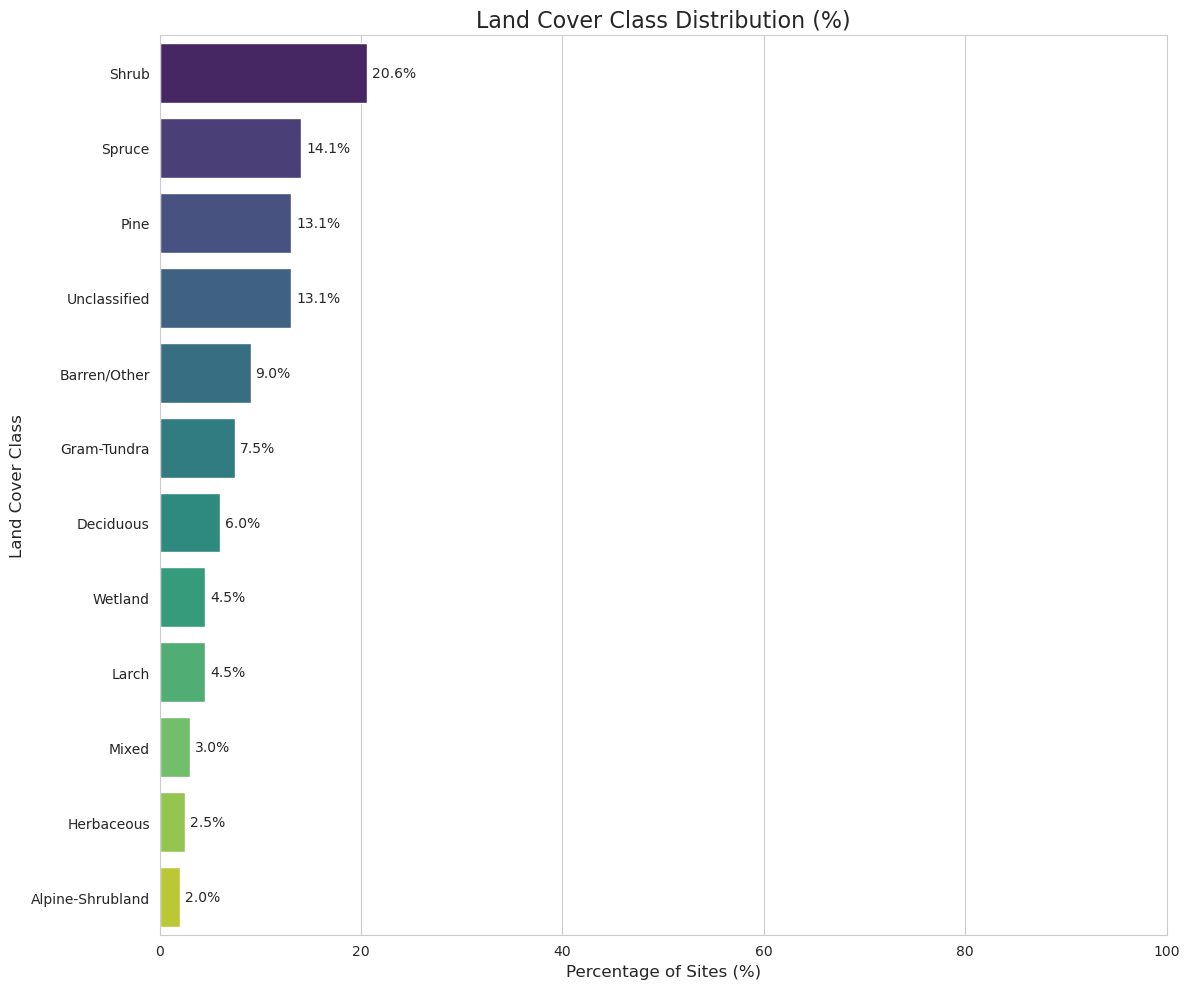

✅ Done.
Preview of class percentages:
  land_cover_name  Percentage
0           Shrub   20.603015
1          Spruce   14.070352
2            Pine   13.065327
3    Unclassified   13.065327
4    Barren/Other    9.045226


In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Paths
extracted_values_csv = "/explore/nobackup/people/spotter5/anna_v/v2/extracted_landcover_values_v2.csv"
plot_output_path     = "/explore/nobackup/people/spotter5/anna_v/v2/landcover_distribution_sites_percent.png"

print("Loading extracted landcover data...")
sites_df = pd.read_csv(extracted_values_csv)

# Drop nodata values if present
if 'land_cover_code' in sites_df.columns:
    sites_df = sites_df[sites_df['land_cover_code'] != -9999]

# Count percentages of each land cover name
class_percentages = sites_df['land_cover_name'].value_counts(normalize=True) * 100
class_percentages_df = (
    class_percentages.rename("Percentage")
    .reset_index()
    .rename(columns={"index": "land_cover_name"})
    .sort_values("Percentage", ascending=False)
)

# Plot
print(f"Generating plot and saving to {plot_output_path}...")
plt.figure(figsize=(12, 10))
sns.set_style("whitegrid")

ax = sns.barplot(
    data=class_percentages_df,
    x="Percentage",
    y="land_cover_name",
    palette="viridis"
)

ax.set_title("Land Cover Class Distribution (%)", fontsize=16)
ax.set_xlabel("Percentage of Sites (%)", fontsize=12)
ax.set_ylabel("Land Cover Class", fontsize=12)
ax.set_xlim(0, 100)

# Annotate bars with percentages
for i, pct in enumerate(class_percentages_df["Percentage"].round(1)):
    ax.text(pct + 0.5, i, f"{pct}%", va="center")

plt.tight_layout()
plt.savefig(plot_output_path, dpi=300)
plt.show()
plt.close()

print("✅ Done.")
print("Preview of class percentages:")
print(class_percentages_df.head())


Saved updated data with names -> /explore/nobackup/people/spotter5/anna_v/v2/v2_model_training_data_v3_with_land_cover_names.csv


/explore/nobackup/people/spotter5/temp_dir/ipykernel_2864143/2376722979.py:69: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


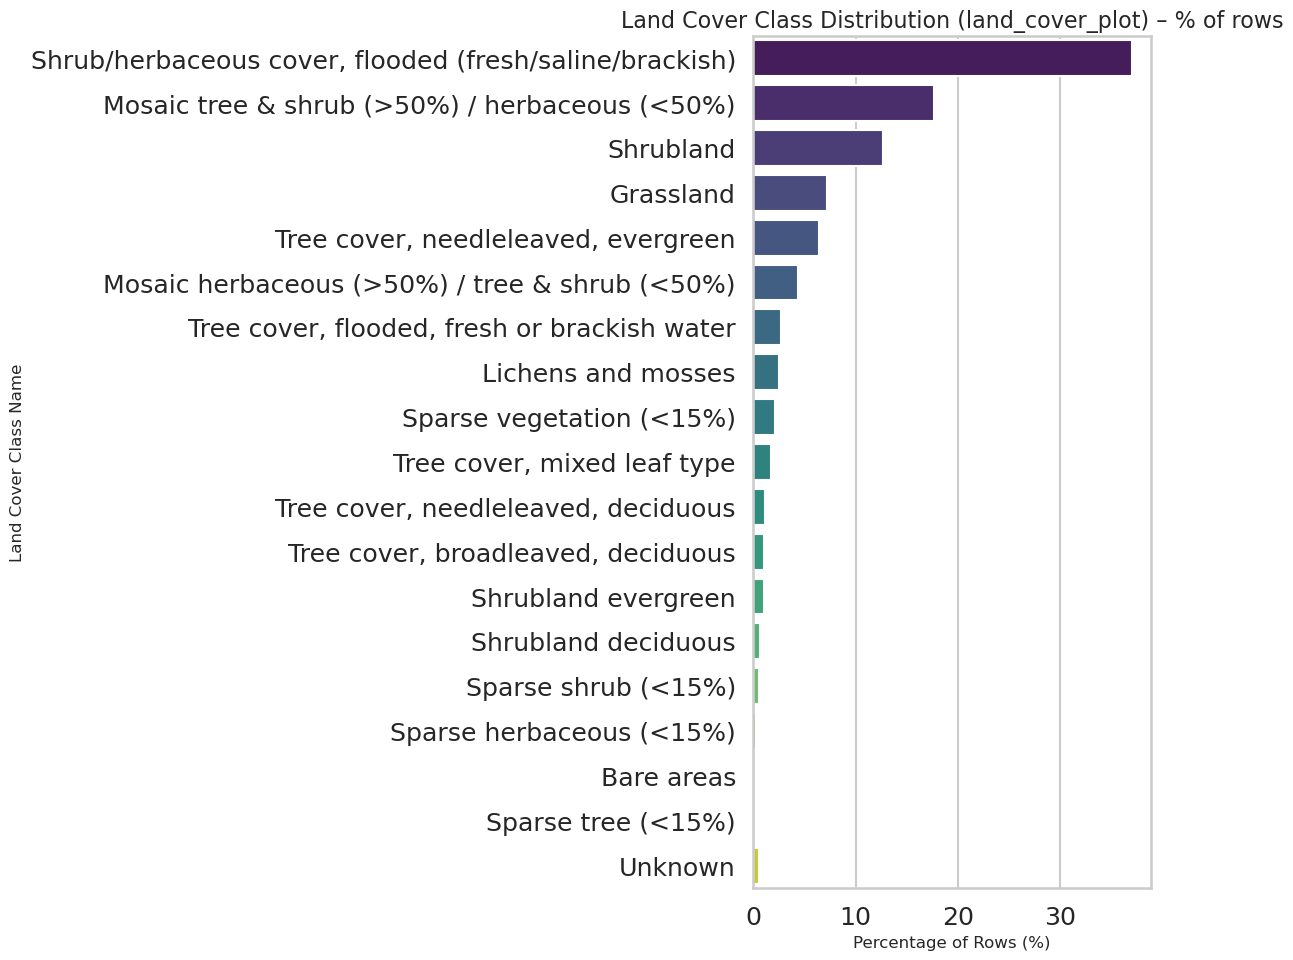

Saved plot -> /explore/nobackup/people/spotter5/anna_v/v2/landcover_distribution_land_cover_plot_percent.png


In [20]:

import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# ----------------- INPUT / OUTPUT -----------------
IN_CSV  = "/explore/nobackup/people/spotter5/anna_v/v2/v2_model_training_data_v3.csv"
OUT_CSV = "/explore/nobackup/people/spotter5/anna_v/v2/v2_model_training_data_v3_with_land_cover_names.csv"
PLOT_PNG = "/explore/nobackup/people/spotter5/anna_v/v2/landcover_distribution_land_cover_plot_percent.png"

os.makedirs(os.path.dirname(PLOT_PNG), exist_ok=True)

# ----------------- LOAD -----------------
df = pd.read_csv(IN_CSV)

# ----------------- REMAP land_cover_plot -> readable names -----------------
landcover_map = {
    40:  "Mosaic natural vegetation (>50%) / cropland (<50%)",
    60:  "Tree cover, broadleaved, deciduous",
    70:  "Tree cover, needleleaved, evergreen",
    80:  "Tree cover, needleleaved, deciduous",
    90:  "Tree cover, mixed leaf type",
    100: "Mosaic tree & shrub (>50%) / herbaceous (<50%)",
    110: "Mosaic herbaceous (>50%) / tree & shrub (<50%)",
    120: "Shrubland",
    121: "Shrubland evergreen",
    122: "Shrubland deciduous",
    130: "Grassland",
    140: "Lichens and mosses",
    150: "Sparse vegetation (<15%)",
    151: "Sparse tree (<15%)",
    152: "Sparse shrub (<15%)",
    153: "Sparse herbaceous (<15%)",
    160: "Tree cover, flooded, fresh or brackish water",
    170: "Tree cover, flooded, saline water",
    180: "Shrub/herbaceous cover, flooded (fresh/saline/brackish)",
    200: "Bare areas",
    210: "Water bodies",
}

# ensure the source column exists
if "land_cover_eco" not in df.columns:
    raise KeyError("Column 'land_cover_eco' not found in the input CSV.")

# if the column is string-typed, coerce to numeric first
df["land_cover_eco"] = pd.to_numeric(df["land_cover_eco"], errors="coerce")

# map to readable names; keep 'Unknown' for anything unmapped/NaN
df["land_cover_eco_name"] = df["land_cover_eco"].map(landcover_map).fillna("Unknown")

# ----------------- SAVE UPDATED CSV (optional but handy) -----------------
# df.to_csv(OUT_CSV, index=False)
print(f"Saved updated data with names -> {OUT_CSV}")

# ----------------- PERCENTAGE BAR PLOT -----------------
sns.set_style("whitegrid")

# compute percentages
pct = (
    df["land_cover_eco_name"]
      .value_counts(normalize=True, dropna=False) * 100.0
).rename_axis("Class_Name").reset_index(name="Percentage")

# put 'Unknown' at the bottom by sorting: first by whether it's Unknown, then by percentage desc
pct["is_unknown"] = (pct["Class_Name"] == "Unknown").astype(int)
pct = pct.sort_values(["is_unknown", "Percentage"], ascending=[True, False]).drop(columns="is_unknown")

plt.figure(figsize=(12, 10))
ax = sns.barplot(
    data=pct,
    x="Percentage",
    y="Class_Name",
    palette="viridis"
)
ax.set_title("Land Cover Class Distribution (land_cover_plot) – % of rows", fontsize=16)
ax.set_xlabel("Percentage of Rows (%)", fontsize=12)
ax.set_ylabel("Land Cover Class Name", fontsize=12)
plt.tight_layout()
plt.savefig(PLOT_PNG, dpi=200)
plt.show()
plt.close()
print(f"Saved plot -> {PLOT_PNG}")


In [9]:

df = = pd.read_csv("/explore/nobackup/people/spotter5/anna_v/v2/v2_model_training_data_v3.csv")
df['land_cover_plot'].unique()



array([ 90.,  70.,  60., 140., 180., 160., 200., 121., 130., 122., 110.,
       152.,  80., 100., 120., 153., 150., 210., 151.,  nan])

In [6]:
df['land_cover_plot']

40=Mosaic natural vegetation (tree, shrub, herbaceous cover) (>50%) / cropland (<50%);
60=Tree cover, broadleaved, deciduous;
70=Tree cover, needleleaved, evergreen;
80=Tree cover, needleleaved, deciduous;
90=Tree cover, mixed leaf type (broadleaved and needleleaved);
100=Mosaic tree and shrub (>50%) / herbaceous cover (<50%);
110=Mosaic herbaceous cover (>50%) / tree and shrub (<50%);
120=Shrubland;
121=Shrubland evergreen;
122=Shrubland deciduous;
130=Grassland;
140=Lichens and mosses;
150=Sparse vegetation (tree, shrub, herbaceous cover) (<15%);
151=Sparse tree (<15%);
152=Sparse shrub (<15%)
153=Sparse herbaceous cover (<15%);
160=Tree cover, flooded, fresh or brakish water;
170=Tree cover, flooded, saline water;
180=Shrub or herbaceous cover, flooded, fresh/saline/brakish water;
200=Bare areas;
210= Water bodies


0          90.0
1          90.0
2          90.0
3          90.0
4          90.0
          ...  
645037    121.0
645038     70.0
645039     70.0
645040     70.0
645041     70.0
Name: land_cover_plot, Length: 645042, dtype: float64

Loading TEM-equivalent site-level data (with land_cover_name)...
Loading flux data and dropping duplicate site_reference...
Using site-level/original class column: site_level_name
Joining TEM land_cover_name with site-level/original class on site_reference...
Unique site_reference in TEM file:   187
Unique site_reference in flux file:  188
Unique site_reference after join:    187
⚠️  Note: joined unique sites = 187, expected ≈ 2130.
Saved crosswalk counts → /explore/nobackup/people/spotter5/anna_v/v2/crosswalk_SITELEVEL_to_TEM_counts.csv
Saved crosswalk row %  → /explore/nobackup/people/spotter5/anna_v/v2/crosswalk_SITELEVEL_to_TEM_rowpct.csv


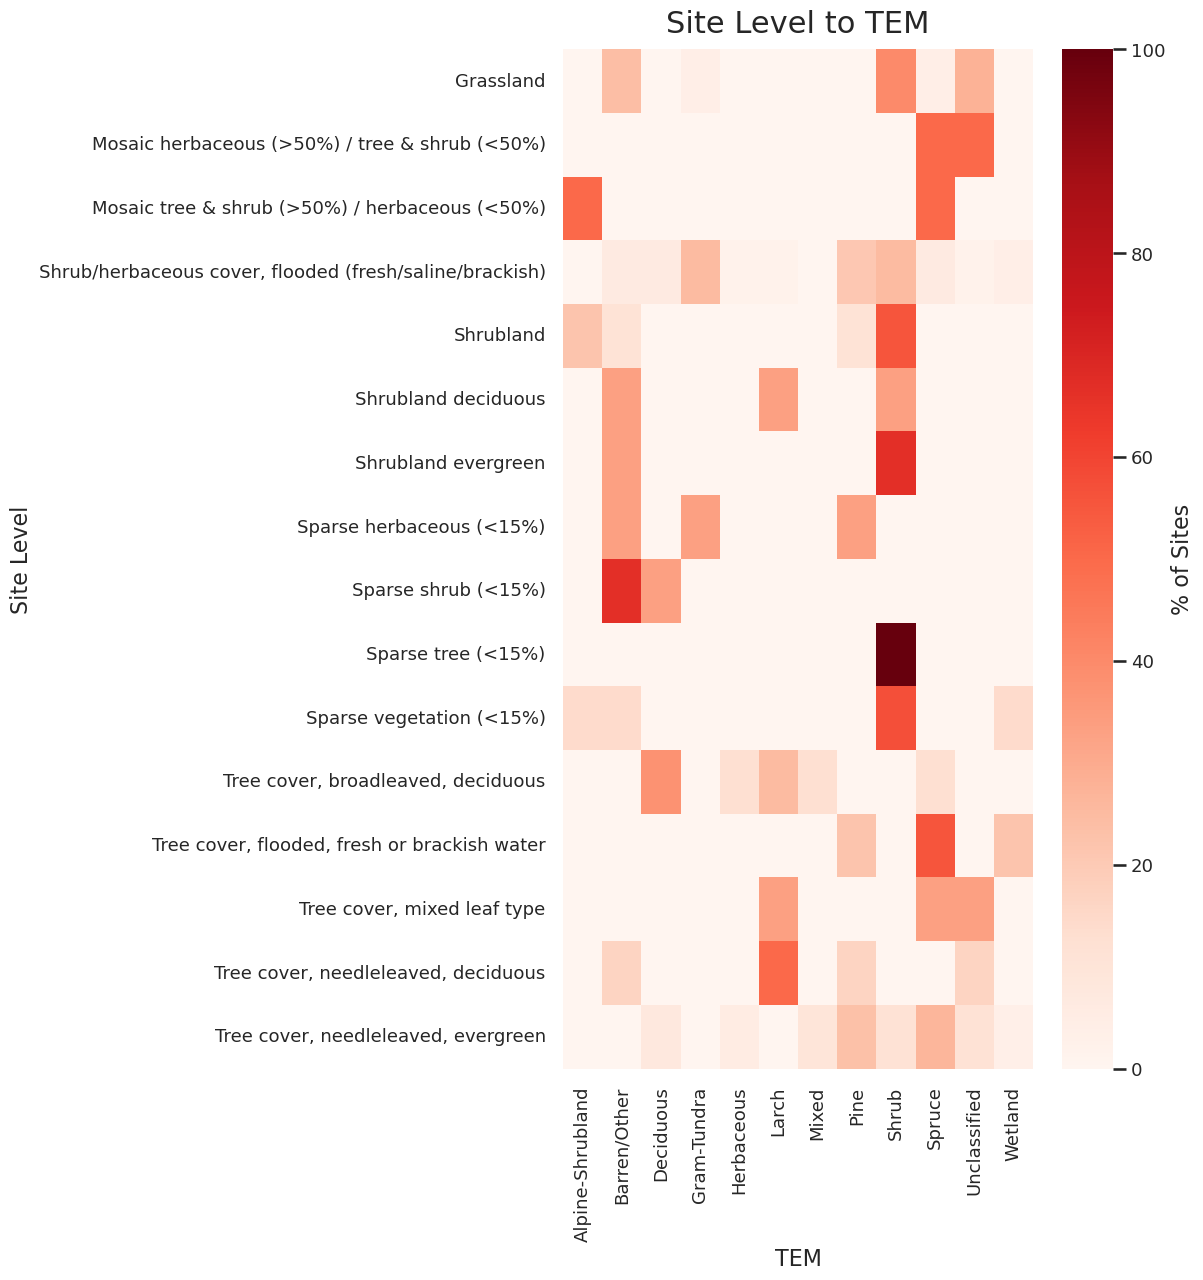

Saved crosswalk heatmap → /explore/nobackup/people/spotter5/anna_v/v2/site_level_to_tem_heat.png

Done.


In [22]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# ----------------- STYLE -----------------
plt.rcParams.update({
    "font.size": 14,
    "axes.titlesize": 22,
    "axes.labelsize": 16,
    "xtick.labelsize": 13,
    "ytick.labelsize": 13,
    "legend.fontsize": 14,
    "figure.titlesize": 24
})
sns.set_context("talk", font_scale=1.1)
sns.set_style("whitegrid")

# ----------------- INPUTS -----------------
tem_sites_csv   = "/explore/nobackup/people/spotter5/anna_v/v2/extracted_landcover_values_v2.csv"  # has land_cover_name (TEM)
flux_data_path  = "/explore/nobackup/people/spotter5/anna_v/v2/v2_model_training_final.csv"       # site-level/original info

# ----------------- OUTPUTS -----------------
out_dir = "/explore/nobackup/people/spotter5/anna_v/v2"
os.makedirs(out_dir, exist_ok=True)

crosswalk_counts_csv  = os.path.join(out_dir, "crosswalk_SITELEVEL_to_TEM_counts.csv")
crosswalk_rowpct_csv  = os.path.join(out_dir, "crosswalk_SITELEVEL_to_TEM_rowpct.csv")
crosswalk_heatmap_png = os.path.join(out_dir, "site_level_to_tem_heat.png")

EXPECTED_UNIQUE_SITES = 2130  # as you noted

# ----------------- LOAD TEM (NEW) -----------------
print("Loading TEM-equivalent site-level data (with land_cover_name)...")
tem_sites = pd.read_csv(tem_sites_csv)

# Normalize site id column name
if 'site_reference' not in tem_sites.columns and 'site_refer' in tem_sites.columns:
    tem_sites = tem_sites.rename(columns={'site_refer': 'site_reference'})
if 'site_reference' not in tem_sites.columns:
    raise KeyError("site_reference (or site_refer) not found in TEM sites CSV.")

# Drop nodata if present
if 'land_cover_code' in tem_sites.columns:
    tem_sites = tem_sites[tem_sites['land_cover_code'] != -9999]

# Keep only needed columns + dedupe on site_reference
tem_sites = tem_sites[['site_reference', 'land_cover_name']].drop_duplicates(subset=['site_reference'])

# ----------------- LOAD FLUX + DEDUPE -----------------
print("Loading flux data and dropping duplicate site_reference...")
flux_df = pd.read_csv(flux_data_path)
if 'site_reference' not in flux_df.columns and 'site_refer' in flux_df.columns:
    flux_df = flux_df.rename(columns={'site_refer': 'site_reference'})
if 'site_reference' not in flux_df.columns:
    raise KeyError("site_reference (or site_refer) not found in flux CSV.")

flux_df = flux_df.drop_duplicates(subset=['site_reference']).copy()

# ----------------- DETECT / BUILD SITE-LEVEL (ORIGINAL) CLASS NAME -----------------
# Priority 1: existing readable name
site_level_name_col = None
if 'land_cover_eco_name' in flux_df.columns:
    site_level_name_col = 'land_cover_eco_name'
else:
    # Priority 2: integer codes -> map to readable names
    if 'land_cover_plot' in flux_df.columns:
        landcover_map = {
            40:  "Mosaic natural vegetation (>50%) / cropland (<50%)",
            60:  "Tree cover, broadleaved, deciduous",
            70:  "Tree cover, needleleaved, evergreen",
            80:  "Tree cover, needleleaved, deciduous",
            90:  "Tree cover, mixed leaf type",
            100: "Mosaic tree & shrub (>50%) / herbaceous (<50%)",
            110: "Mosaic herbaceous (>50%) / tree & shrub (<50%)",
            120: "Shrubland",
            121: "Shrubland evergreen",
            122: "Shrubland deciduous",
            130: "Grassland",
            140: "Lichens and mosses",
            150: "Sparse vegetation (<15%)",
            151: "Sparse tree (<15%)",
            152: "Sparse shrub (<15%)",
            153: "Sparse herbaceous (<15%)",
            160: "Tree cover, flooded, fresh or brackish water",
            170: "Tree cover, flooded, saline water",
            180: "Shrub/herbaceous cover, flooded (fresh/saline/brackish)",
            200: "Bare areas",
            210: "Water bodies",
        }
        flux_df['land_cover_eco'] = pd.to_numeric(flux_df['land_cover_eco'], errors='coerce')
        flux_df['site_level_name'] = flux_df['land_cover_plot'].map(landcover_map).fillna("Unknown")
        site_level_name_col = 'site_level_name'
    else:
        # Priority 3: search for a plausible original name column that mentions "plot"
        candidates = [c for c in flux_df.columns if 'plot' in c.lower() and flux_df[c].dtype == object]
        if candidates:
            site_level_name_col = candidates[0]  # pick the first plausible string column
        else:
            raise RuntimeError(
                "Could not find a site-level/original class column in flux file. "
                "Expected 'land_cover_plot_name' OR 'land_cover_plot' (int) to map."
            )

print(f"Using site-level/original class column: {site_level_name_col}")

# Keep minimal flux columns
flux_keep = flux_df[['site_reference', site_level_name_col]].copy()

# ----------------- JOIN (ONLY ON site_reference) -----------------
print("Joining TEM land_cover_name with site-level/original class on site_reference...")
joined = tem_sites.merge(flux_keep, on='site_reference', how='inner', validate='one_to_one')

n_unique_joined = joined['site_reference'].nunique()
n_unique_tem    = tem_sites['site_reference'].nunique()
n_unique_flux   = flux_keep['site_reference'].nunique()

print(f"Unique site_reference in TEM file:   {n_unique_tem}")
print(f"Unique site_reference in flux file:  {n_unique_flux}")
print(f"Unique site_reference after join:    {n_unique_joined}")

if n_unique_joined != EXPECTED_UNIQUE_SITES:
    print(f"⚠️  Note: joined unique sites = {n_unique_joined}, expected ≈ {EXPECTED_UNIQUE_SITES}.")

# ----------------- BUILD CROSSWALK (ORIGINAL → TEM) -----------------
original_col = site_level_name_col              # rows
tem_col      = 'land_cover_name'               # columns

counts = pd.crosstab(
    joined[original_col],
    joined[tem_col],
    dropna=False
)

row_pct = counts.div(counts.sum(axis=1).replace(0, np.nan), axis=0) * 100.0

# Save tables
# counts.to_csv(crosswalk_counts_csv)
# row_pct.to_csv(crosswalk_rowpct_csv)
print(f"Saved crosswalk counts → {crosswalk_counts_csv}")
print(f"Saved crosswalk row %  → {crosswalk_rowpct_csv}")

# ----------------- HEATMAP (ROW %) — REDS -----------------
fig, ax = plt.subplots(
    figsize=(
        max(12, 0.45 * row_pct.shape[1] + 6),
        max(10, 0.45 * row_pct.shape[0] + 6)
    )
)
hm = sns.heatmap(
    row_pct.fillna(0.0),
    cmap="Reds",
    annot=False,
    cbar_kws={'label': 'Row % (Original → TEM)'},
    ax=ax
)
ax.set_title("Site Level to TEM", fontsize=22, pad=12)
ax.set_xlabel("TEM", fontsize=16)
ax.set_ylabel("Site Level", fontsize=16)
ax.tick_params(axis='both', labelsize=13)

cbar = hm.collections[0].colorbar
cbar.ax.tick_params(labelsize=13)
cbar.set_label('% of Sites', fontsize=16)

plt.tight_layout()
plt.savefig(crosswalk_heatmap_png, dpi=300)
plt.show()
plt.close(fig)
print(f"Saved crosswalk heatmap → {crosswalk_heatmap_png}")

print("\nDone.")


,site_name,site_reference,latitude,longitude,flux_method,country,land_cover_eco,land_cover_plot,bawld_class,year,...,phh2o_0_100cm,sand_0_100cm,silt_0_100cm,soc_0_100cm,land_cover,co2_cont,ALT,sm_surface,sm_rootzone,site_level_name
0,Skyttorp 2,Skyttorp 2_SE-Sk2_tower,60.129667,17.840056,EC,Sweden,70.0,70.0,Boreal Forest,2000,...,NaN,NaN,NaN,NaN,7,376.89,NaN,0.339861,0.331989,"Tree cover, needleleaved, evergreen"
1,Wolf_creek_forest,Wolf_creek_forest_CA-WCF_tower,60.596886,-134.952833,EC,Canada,70.0,70.0,Boreal Forest,2000,...,7.352632,55.487802,28.810267,11.866563,6,376.89,1.10,0.253667,0.185445,"Tree cover, needleleaved, evergreen"
2,"Alberta - Western Peatland - LaBiche River,Bla...","Alberta - Western Peatland - LaBiche River,Bla...",54.953840,-112.466980,EC,Canada,160.0,160.0,Fen,2000,...,6.252252,50.121325,30.162230,35.182187,1,374.96,NaN,0.187536,0.207688,"Tree cover, flooded, fresh or brackish water"
3,Elgeeii forest station,Elgeeii forest station_RU-Ege_tower,60.015516,133.824012,EC,Russia,90.0,90.0,Boreal Forest,2000,...,7.130071,41.499711,31.082185,53.577813,4,374.96,1.25,0.158696,0.128285,"Tree cover, mixed leaf type"
4,Faejemyr,Faejemyr_SE-Faj_tower,56.265500,13.553500,EC,Sweden,180.0,180.0,Bog,2000,...,NaN,NaN,NaN,NaN,13,374.96,NaN,0.343885,0.308715,"Shrub/herbaceous cover, flooded (fresh/saline/..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
429,ARM-NSA-Barrow,ARM-NSA-Barrow_US-A10_tower,71.323000,-156.609000,EC,USA,153.0,153.0,Wet Tundra,2000,...,5.729838,42.321892,35.450215,146.161786,11,365.93,0.10,0.660216,0.897525,Sparse herbaceous (<15%)
445,Barrow-CMDL,Barrow-CMDL_US-Brw_tower,71.322525,-156.609200,EC,USA,180.0,180.0,Wet Tundra,2000,...,5.729838,42.321892,35.450215,146.161786,11,365.93,0.10,0.660216,0.897525,"Shrub/herbaceous cover, flooded (fresh/saline/..."
446,"Bayelva, Spitsbergen","Bayelva, Spitsbergen_SJ-Blv_tower",78.921600,11.831100,EC,Norway,130.0,130.0,Dry Tundra,2000,...,6.635809,48.753676,32.812848,114.911250,12,365.93,0.20,NaN,NaN,Grassland
457,Central Marsh,Central Marsh_US-Cms_tower,71.320190,-156.622270,EC,USA,180.0,180.0,Wet Tundra,2000,...,5.961217,40.754235,38.025357,145.951923,11,365.93,0.10,0.660208,0.897604,"Shrub/herbaceous cover, flooded (fresh/saline/..."


In [23]:
joined

,site_reference,land_cover_name,site_level_name
0,Fyodorovskoye_RU-Fyo_tower,Unclassified,"Tree cover, needleleaved, evergreen"
1,"Saskatchewan - Western Boreal, Mature Aspen_CA...",Deciduous,"Tree cover, broadleaved, deciduous"
2,"Saskatchewan - Western Boreal, Mature Jack Pin...",Pine,"Tree cover, needleleaved, evergreen"
3,Flakaliden_SE-Fla_tower,Pine,"Tree cover, needleleaved, evergreen"
4,Hyytiala_FI-Hyy_tower,Mixed,"Tree cover, needleleaved, evergreen"
...,...,...,...
182,Gunnarsholt_IS-Gun_tower,Herbaceous,"Tree cover, broadleaved, deciduous"
183,Happy Valley Wet Sedge Tundra_US-HVs_tower,Shrub,Grassland
184,Happy Valley_US-HVa_tower,Shrub,"Shrub/herbaceous cover, flooded (fresh/saline/..."
185,Sag River_US-Sag_tower,Shrub,"Shrub/herbaceous cover, flooded (fresh/saline/..."


In [41]:
counts

land_cover_name,Deciduous,Gram-Wet,Herbaceous,Larch,Mixed,Pine,Shrub,Spruce,Unclassified,barren/other,wetland
site_level_name,,,,,,,,,,,
Grassland,0,0,1,0,1,0,6,0,11,6,0
Mosaic herbaceous (>50%) / tree & shrub (<50%),0,0,0,0,0,0,0,1,1,0,0
Mosaic tree & shrub (>50%) / herbaceous (<50%),0,0,0,0,1,0,1,0,0,0,0
"Shrub/herbaceous cover, flooded (fresh/saline/brackish)",1,2,1,0,3,10,9,1,6,14,1
Shrubland,0,0,1,0,0,1,6,0,0,0,1
Shrubland deciduous,1,0,0,0,0,0,1,0,0,1,0
Shrubland evergreen,0,0,0,0,0,0,2,0,0,1,0
Sparse herbaceous (<15%),0,0,0,0,0,2,0,0,1,3,0
Sparse shrub (<15%),0,0,0,0,0,1,0,0,2,0,0


In [42]:
counts.values.sum()

np.int64(186)

In [32]:
t = pd.read_csv( "/explore/nobackup/people/spotter5/anna_v/v2/v2_model_training_final.csv")

t = t.drop_duplicates(['site_reference'])

t.shape

(188, 57)

In [33]:
t.site_reference.unique()

array(['Skyttorp 2_SE-Sk2_tower', 'Wolf_creek_forest_CA-WCF_tower',
       'Alberta - Western Peatland - LaBiche River,Black Spruce,Larch Fen_CA-WP1_tower',
       'Elgeeii forest station_RU-Ege_tower', 'Faejemyr_SE-Faj_tower',
       'Fyodorovskoye2_RU-Fy2_tower', 'Fyodorovskoye_RU-Fyo_tower',
       'Gunnarsholt_IS-Gun_tower', 'HJP02 Jack Pine_CA-HJP02_tower',
       'HJP75 Jack Pine_CA-HJP75_tower', 'HJP94 Jack Pine_CA-HJP94_tower',
       'Hakasia 10 yr_RU-Ha3_tower', 'Hakasia 5yr_RU-Ha2_tower',
       'Hakasia Steppe_RU-Ha1_tower', 'Hustai grassland_MN-Hst_tower',
       'Hyltemossa_SE-Htm_tower', 'Kherlenbayan Ulaan_MN-Kbu_tower',
       'Norunda_SE-Nor_tower',
       'Ontario - Groundhog River, Boreal Mixedwood Forest_CA-Gro_tower',
       'Pitsalu_tower', 'Pond Inlet_CA-Pin_tower',
       'Saskatchewan - Western Boreal, Jack Pine harvested in 1975_CA-SJ3_tower',
       'Saskatchewan - Western Boreal, Jack Pine harvested in 2002_CA-SJ2_tower',
       'Saskatchewan - Western Bore

In [2]:
import pandas as pd
t2 = pd.read_csv("/explore/nobackup/people/spotter5/anna_v/v2/extracted_landcover_values_v2.csv")

t2

,site_refer,latitude,longitude,land_cover_code,land_cover_name
0,Fyodorovskoye_RU-Fyo_tower,56.461528,32.922083,11,Unclassified
1,"Saskatchewan - Western Boreal, Mature Aspen_CA...",53.628900,-106.197800,1,Spruce
2,"Saskatchewan - Western Boreal, Mature Jack Pin...",53.916300,-104.692000,1,Spruce
3,Flakaliden_SE-Fla_tower,64.112778,19.456944,0,Pine
4,Hyytiala_FI-Hyy_tower,61.847400,24.294800,4,Larch
...,...,...,...,...,...
201,Happy Valley Wet Sedge Tundra_US-HVs_tower,69.167200,-148.856900,6,Shrub
202,Happy Valley_US-HVa_tower,69.142300,-148.841200,6,Shrub
203,Sag River_US-Sag_tower,69.505600,-148.225000,6,Shrub
204,"Stordalen, Sweden_Stordalen_tower",68.370000,19.050000,11,Unclassified
